# A simple example where we train a continuous-normalizing flow by maximum-likelihood.

Continuous-normalizing flows (CNFs) nowadays are frequently trained using flow matching and related techniques. Flow matching is simulation-free, highly scalable, and has desmonstrated strong empirical performance. 
Before the invention of flow matching and related techniques, CNFs training was much slower and used the technique of maximum likelihood, where we do not prescribe a target velocity field (as in FM) and solely train the neural ODE based on the log-likelihood of the data under the model.
Here we demonstrate how to do this on a toy 2D example.

In [1]:
D = 2  # Data dimensionality

In [2]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torch.distributions import Independent, Normal


In [3]:
from flow_matching.utils import ModelWrapper
from flow_matching.solver import ODESolver

class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        t = t.view(1, 1).expand(x.shape[0], 1)   # nn model requires time to be [batch_size].
        return self.model(t, x)


In [4]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

In [5]:
def get_data_batch(batch_size):
    return Tensor(make_moons(batch_size, noise=0.1)[0])

## Plot data

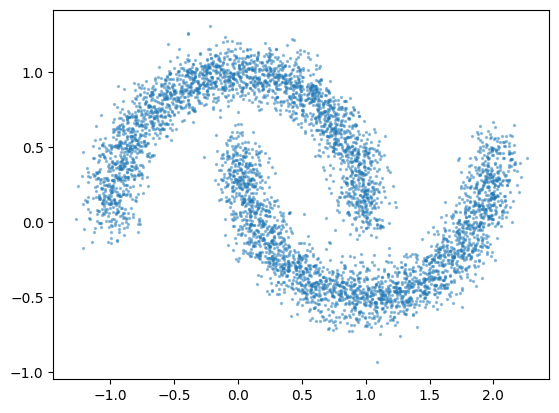

In [6]:
X = get_data_batch(5000)
X = X.numpy()
plt.scatter(X[:, 0], X[:, 1], s=2, alpha=0.4)

## Train a continuous-normalizing flow with maximum-likelihood

Setting `exact_divergence=True` will calculate the log-likelihood using the exact Instantaneous Change of Variables formula (see eq 8 of the [neural ODE paper](https://arxiv.org/pdf/1806.07366)), whereas setting `exact_divergence=False` will approximate the required trace computation with a Monte-Carlo estimator as in [FFJORD](https://arxiv.org/abs/1810.01367).

In [7]:
exact_divergence = True
# exact_divergence = False

In [8]:
p_init = Independent(Normal(torch.zeros(D), torch.ones(D)), 1)

In [9]:
flow = Flow()
wrapped_flow = WrappedModel(flow)
solver = ODESolver(velocity_model=wrapped_flow) 

optimizer = torch.optim.Adam(flow.parameters(), 1e-3)

losses = []

for i in range(2000):
    x_1 = get_data_batch(batch_size=256)

    # z, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=0.05, exact_divergence=exact_divergence, log_p0=p_init.log_prob, enable_grad=True)
    z, log_p = solver.compute_likelihood(x_1=x_1, method='dopri5', step_size=None, exact_divergence=exact_divergence, log_p0=p_init.log_prob, enable_grad=True)
    loss = -log_p.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(float(loss))

    if i % 500 == 0:
        print(f'Step {i}, loss={float(loss)}')

Step 0, loss=2.4170706272125244
Step 500, loss=1.2355551719665527
Step 1000, loss=1.1878902912139893
Step 1500, loss=1.1545876264572144


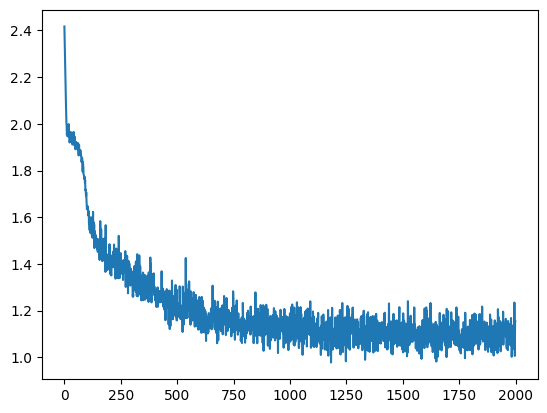

In [10]:
plt.plot(losses)

## Compare true v.s. generated samples

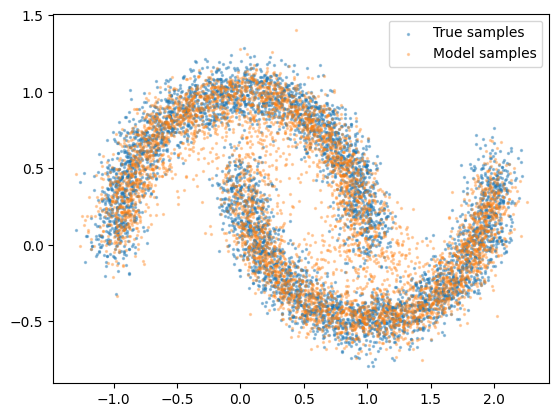

In [11]:
n_samples = 5000
x_init = p_init.sample((n_samples,))
samples = solver.sample(x_init=x_init, method='dopri5', step_size=None, return_intermediates=False)  # sample from the model

# Plot true:
X = get_data_batch(n_samples)
X = X.numpy()
plt.scatter(X[:, 0], X[:, 1], s=2, alpha=0.4, label='True samples')

# Plot generated:
plt.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.3, label='Model samples')

plt.legend()

## Plot sampling trajectory across time.

In [12]:
n_samples = 1000
n_steps = 10
T = torch.linspace(0,1,n_steps)
x_init = p_init.sample((n_samples,))
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=None, return_intermediates=True)  # sample from the model

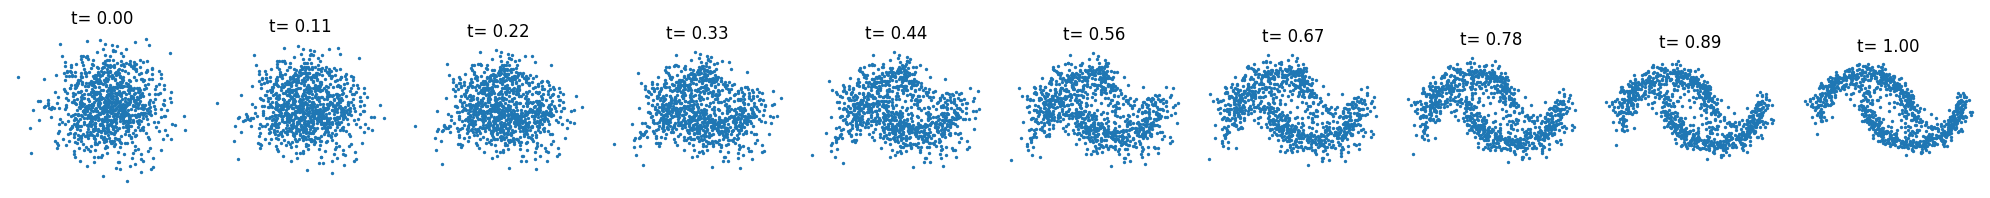

In [13]:
from matplotlib import cm
fig, axs = plt.subplots(1, 10,figsize=(20,20))

for i in range(10):
    axs[i].scatter(sol[i,:,0], sol[i,:,1], s=2)
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()